# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from sklearn.metrics import recall_score, f1_score, precision_score


---

# Color

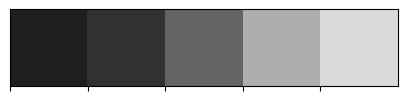

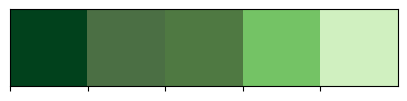

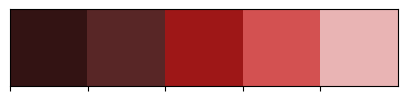

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [ ]:
labels = ['NO', 'YES']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Br35H-Dataset','TRAINING',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Br35H-Dataset','TESTING',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 801/801 [00:09<00:00, 86.87it/s] 


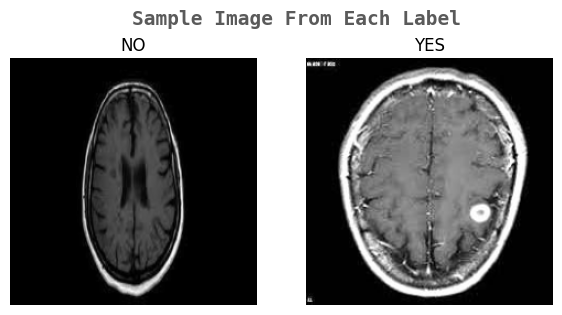

In [ ]:
k=0
fig, ax = plt.subplots(1,2,figsize=(7,7))
fig.text(s='Sample Image From Each Label',size=14,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.72,x=0.3,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3801, 224, 224, 3)

In [ ]:
y_train.shape

(3801,)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

In [ ]:
def create_efficientNetB_models(image_size):
    # Create EfficientNetB0 Model
    effnet0 = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Create EfficientNetB1 Model
    effnet1 = EfficientNetB1(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Create EfficientNetB2 Model
    effnet2 = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Create EfficientNetB3 Model
    effnet3 = EfficientNetB3(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Create EfficientNetB4 Model
    effnet4 = EfficientNetB4(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Create EfficientNetB5 Model
    effnet5 = EfficientNetB5(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Create EfficientNetB6 Model
    effnet6 = EfficientNetB6(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Create EfficientNetB7 Model
    effnet7 = EfficientNetB7(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

    # Store models in a dictionary
    efficientNetB_models = {
        'effnet0': effnet0,
        'effnet1': effnet1,
        'effnet2': effnet2,
        'effnet3': effnet3,
        'effnet4': effnet4,
        'effnet5': effnet5,
        'effnet6': effnet6,
        'effnet7': effnet7
    }

    return efficientNetB_models

In [ ]:
models_dict = create_efficientNetB_models(image_size)

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
# Access models
effnet0_model_instance = models_dict['effnet0']
effnet1_model_instance = models_dict['effnet1']
effnet2_model_instance = models_dict['effnet2']
effnet3_model_instance = models_dict['effnet3']
effnet4_model_instance = models_dict['effnet4']
effnet5_model_instance = models_dict['effnet5']
effnet6_model_instance = models_dict['effnet6']
effnet7_model_instance = models_dict['effnet7']

In [ ]:
def compile_tensorflow_models(loss, metrics, optimizer):
    # Model 0
    model0 = effnet0_model_instance.output
    model0 = tf.keras.layers.GlobalAveragePooling2D()(model0)
    model0 = tf.keras.layers.Dropout(rate=0.5)(model0)
    model0 = tf.keras.layers.Dense(2,activation='softmax')(model0)
    model0 = tf.keras.models.Model(inputs=effnet0_model_instance.input, outputs = model0)

    # Compile Model 0
    model0.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Model 1
    model1 = effnet1_model_instance.output
    model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
    model1 = tf.keras.layers.Dropout(rate=0.5)(model1)
    model1 = tf.keras.layers.Dense(2,activation='softmax')(model1)
    model1 = tf.keras.models.Model(inputs=effnet1_model_instance.input, outputs = model1)

    # Compile Model 1
    model1.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Model 2
    model2 = effnet2_model_instance.output
    model2= tf.keras.layers.GlobalAveragePooling2D()(model2)
    model2 = tf.keras.layers.Dropout(rate=0.5)(model2)
    model2 = tf.keras.layers.Dense(2,activation='softmax')(model2)
    model2 = tf.keras.models.Model(inputs=effnet2_model_instance.input, outputs = model2)

    # Compile Model 2
    model2.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Model 3
    model3 = effnet3_model_instance.output
    model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
    model3 = tf.keras.layers.Dropout(rate=0.5)(model3)
    model3 = tf.keras.layers.Dense(2,activation='softmax')(model3)
    model3 = tf.keras.models.Model(inputs=effnet3_model_instance.input, outputs = model3)

   # Compile Model 3
    model3.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Model 4
    model4 = effnet4_model_instance.output
    model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
    model4 = tf.keras.layers.Dropout(rate=0.5)(model4)
    model4 = tf.keras.layers.Dense(2,activation='softmax')(model4)
    model4 = tf.keras.models.Model(inputs=effnet4_model_instance.input, outputs = model4)

    # Compile Model 4
    model4.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Model 5
    model5 = effnet5_model_instance.output
    model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
    model5 = tf.keras.layers.Dropout(rate=0.5)(model5)
    model5 = tf.keras.layers.Dense(2,activation='softmax')(model5)
    model5 = tf.keras.models.Model(inputs=effnet5_model_instance.input, outputs = model5)

    # Compile Model 5
    model5.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Model 6
    model6 = effnet6_model_instance.output
    model6 = tf.keras.layers.GlobalAveragePooling2D()(model6)
    model6 = tf.keras.layers.Dropout(rate=0.5)(model6)
    model6 = tf.keras.layers.Dense(2,activation='softmax')(model6)
    model6 = tf.keras.models.Model(inputs=effnet6_model_instance.input, outputs = model6)

    # Compile Model 6
    model6.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Model 7
    model7 = effnet7_model_instance.output
    model7 = tf.keras.layers.GlobalAveragePooling2D()(model7)
    model7 = tf.keras.layers.Dropout(rate=0.5)(model7)
    model7 = tf.keras.layers.Dense(2,activation='softmax')(model7)
    model7 = tf.keras.models.Model(inputs=effnet7_model_instance.input, outputs = model7)

    # Compile Model 7
    model7.compile(loss=loss, optimizer = optimizer, metrics= metrics)

    # Return a list of compiled models
    compiled_models = [model0, model1, model2, model3, model4, model5, model6, model7]

    return compiled_models

In [ ]:
loss = 'binary_crossentropy'
metrics = ['accuracy']
optimizer = 'Adam'

compiled_models_list = compile_tensorflow_models(loss, metrics, optimizer)

In [ ]:
# Access compiled models
model0_compiled = compiled_models_list[0]
model1_compiled = compiled_models_list[1]
model2_compiled = compiled_models_list[2]
model3_compiled = compiled_models_list[3]
model4_compiled = compiled_models_list[4]
model5_compiled = compiled_models_list[5]
model6_compiled = compiled_models_list[6]
model7_compiled = compiled_models_list[7]

CallBack Functions

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5", monitor="val_accuracy", save_best_only=True, mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

In [ ]:
import time

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Train the model on GPU
model0_start_time = time.time()
with tf.device('/GPU:0'):
    history0 = model0_compiled.fit(X_train, y_train, validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model0_train_acc = history0.history['accuracy']
model0_train_loss = history0.history['loss']
model0_val_acc = history0.history['val_accuracy']
model0_val_loss = history0.history['val_loss']

model0_end_time = time.time()
model0_training_time = model0_end_time - model0_start_time

Epoch 1/10
97/97 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9613
Epoch 1: val_accuracy improved from -inf to 0.94152, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 78s 295ms/step - loss: 0.1041 - accuracy: 0.9613 - val_loss: 0.2081 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 2/10
97/97 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9899
Epoch 2: val_accuracy improved from 0.94152 to 0.95614, saving model to effnet.h5
97/97 [==============================] - 26s 270ms/step - loss: 0.0308 - accuracy: 0.9899 - val_loss: 0.2585 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 3/10
97/97 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9955
Epoch 3: val_accuracy improved from 0.95614 to 0.99708, saving model to effnet.h5
97/97 [==============================] - 26s 265ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0046 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 4/10
97/97 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9951
Epoch 4: val_accuracy did not improve from 0.99708
97/97 [==============================] - 25s 260ms/step - loss: 0.01

In [ ]:
model0_train_acc = history0.history['accuracy'][-1]
model0_train_loss = history0.history['loss'][-1]
model0_val_acc = history0.history['val_accuracy'][-1]
model0_val_loss = history0.history['val_loss'][-1]

In [ ]:
model1_start_time = time.time()
with tf.device('/GPU:0'):
  history1 = model1_compiled.fit(X_train,y_train,validation_split=0.1, epochs =9, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model1_train_acc = history1.history['accuracy']
model1_train_loss = history1.history['loss']
model1_val_acc = history1.history['val_accuracy']
model1_val_loss = history1.history['val_loss']

model1_end_time = time.time()

# Calculate training time
model1_training_time = model1_end_time - model1_start_time

Epoch 1/9
97/97 [==============================] - ETA: 0s - loss: 1.1720e-04 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
97/97 [==============================] - 38s 388ms/step - loss: 1.1720e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9971 - lr: 2.4300e-06
Epoch 2/9
97/97 [==============================] - ETA: 0s - loss: 3.3190e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
97/97 [==============================] - 35s 363ms/step - loss: 3.3190e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9971 - lr: 2.4300e-06
Epoch 3/9
97/97 [==============================] - ETA: 0s - loss: 2.1537e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
97/97 [==============================] - 35s 362ms/step - loss: 2.1537e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9971 - lr: 2.4300e-06
Epoch 4/9
97/97 [===

In [ ]:
model1_train_acc = history1.history['accuracy'][-1]
model1_train_loss = history1.history['loss'][-1]
model1_val_acc = history1.history['val_accuracy'][-1]
model1_val_loss = history1.history['val_loss'][-1]

In [ ]:
# Train the model on GPU
model2_start_time = time.time()
with tf.device('/GPU:0'):
  history2 = model2_compiled.fit(X_train,y_train,validation_split=0.1, epochs =8, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model2_train_acc = history2.history['accuracy']
model2_train_loss = history2.history['loss']
model2_val_acc = history2.history['val_accuracy']
model2_val_loss = history2.history['val_loss']

model2_end_time = time.time()

# Calculate training time
model2_training_time = model2_end_time - model2_start_time

Epoch 1/8
97/97 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9545
Epoch 1: val_accuracy did not improve from 1.00000
97/97 [==============================] - 90s 415ms/step - loss: 0.1193 - accuracy: 0.9545 - val_loss: 0.0308 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 2/8
97/97 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9864
Epoch 2: val_accuracy did not improve from 1.00000
97/97 [==============================] - 37s 378ms/step - loss: 0.0375 - accuracy: 0.9864 - val_loss: 0.0124 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 3/8
97/97 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9896
Epoch 3: val_accuracy did not improve from 1.00000
97/97 [==============================] - 37s 384ms/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.1503 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 4/8
97/97 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9945
Epoch 4: val_accuracy did not improve fr

In [ ]:
model2_train_acc = history2.history['accuracy'][-1]
model2_train_loss = history2.history['loss'][-1]
model2_val_acc = history2.history['val_accuracy'][-1]
model2_val_loss = history2.history['val_loss'][-1]

In [ ]:
# Train the model on GPU
model3_start_time = time.time()
with tf.device('/GPU:0'):
  history3 = model3_compiled.fit(X_train,y_train,validation_split=0.1, epochs =9, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model3_train_acc = history3.history['accuracy']
model3_train_loss = history3.history['loss']
model3_val_acc = history3.history['val_accuracy']
model3_val_loss = history3.history['val_loss']

model3_end_time = time.time()

# Calculate training time
model3_training_time = model3_end_time - model3_start_time

Epoch 1/9
97/97 [==============================] - ETA: 0s - loss: 9.8651e-04 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
97/97 [==============================] - 51s 519ms/step - loss: 9.8651e-04 - accuracy: 1.0000 - val_loss: 1.3467e-04 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 2/9
97/97 [==============================] - ETA: 0s - loss: 4.6685e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
97/97 [==============================] - 49s 507ms/step - loss: 4.6685e-04 - accuracy: 1.0000 - val_loss: 1.1864e-04 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 3/9
97/97 [==============================] - ETA: 0s - loss: 8.4310e-04 - accuracy: 0.9997
Epoch 3: val_accuracy did not improve from 1.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
97/97 [==============================] - 50s 511ms/step - loss: 8.4310e-04 - accuracy: 0.9997 - val_loss: 1.3022e-04 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 4/

In [ ]:
model3_train_acc = history3.history['accuracy'][-1]
model3_train_loss = history3.history['loss'][-1]
model3_val_acc = history3.history['val_accuracy'][-1]
model3_val_loss = history3.history['val_loss'][-1]

In [ ]:
# Train the model on GPU
model4_start_time = time.time()
with tf.device('/GPU:0'):
  history4 = model4_compiled.fit(X_train,y_train,validation_split=0.1, epochs =9, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model4_train_acc = history4.history['accuracy']
model4_train_loss = history4.history['loss']
model4_val_acc = history4.history['val_accuracy']
model4_val_loss = history4.history['val_loss']

model4_end_time = time.time()

# Calculate training time
model4_training_time = model4_end_time - model4_start_time

Epoch 1/9
97/97 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9587
Epoch 1: val_accuracy did not improve from 1.00000
97/97 [==============================] - 139s 727ms/step - loss: 0.1163 - accuracy: 0.9587 - val_loss: 0.1291 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 2/9
97/97 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9864
Epoch 2: val_accuracy did not improve from 1.00000
97/97 [==============================] - 64s 662ms/step - loss: 0.0421 - accuracy: 0.9864 - val_loss: 0.0441 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 3/9
97/97 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9877
Epoch 3: val_accuracy did not improve from 1.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
97/97 [==============================] - 65s 675ms/step - loss: 0.0424 - accuracy: 0.9877 - val_loss: 0.1257 - val_accuracy: 0.9678 - lr: 0.0010
Epoch 4/9
97/97 [==============================] - ETA:

In [ ]:
model4_train_acc = history4.history['accuracy'][-1]
model4_train_loss = history4.history['loss'][-1]
model4_val_acc = history4.history['val_accuracy'][-1]
model4_val_loss = history4.history['val_loss'][-1]

In [ ]:
# Train the model on GPU
model5_start_time = time.time()
with tf.device('/GPU:0'):
  history5 = model5_compiled.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model5_train_acc = history5.history['accuracy']
model5_train_loss = history5.history['loss']
model5_val_acc = history5.history['val_accuracy']
model5_val_loss = history5.history['val_loss']

model5_end_time = time.time()

# Calculate training time
model5_training_time = model5_end_time - model5_start_time

Epoch 1/10
97/97 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9503
Epoch 1: val_accuracy improved from -inf to 0.98246, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 206s 1s/step - loss: 0.1510 - accuracy: 0.9503 - val_loss: 0.0527 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 2/10
97/97 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9864
Epoch 2: val_accuracy did not improve from 0.98246
97/97 [==============================] - 89s 914ms/step - loss: 0.0549 - accuracy: 0.9864 - val_loss: 0.2884 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 3/10
97/97 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9893
Epoch 3: val_accuracy did not improve from 0.98246

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
97/97 [==============================] - 90s 929ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.4076 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 4/10
97/97 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9964
Epoch 4: val_accuracy improved from 0.98246 to 1.00000, saving model to effnet.h5
97/97 [=================

In [ ]:
model5_train_acc = history5.history['accuracy'][-1]
model5_train_loss = history5.history['loss'][-1]
model5_val_acc = history5.history['val_accuracy'][-1]
model5_val_loss = history5.history['val_loss'][-1]

In [ ]:
# Train the model on GPU
model6_start_time = time.time()
with tf.device('/GPU:0'):
  history6 = model6_compiled.fit(X_train,y_train,validation_split=0.1, epochs =8, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model6_train_acc = history6.history['accuracy']
model6_train_loss = history6.history['loss']
model6_val_acc = history6.history['val_accuracy']
model6_val_loss = history6.history['val_loss']

model6_end_time = time.time()

# Calculate training time
model6_training_time = model6_end_time - model6_start_time

In [ ]:
model6_train_acc = history6.history['accuracy'][-1]
model6_train_loss = history6.history['loss'][-1]
model6_val_acc = history6.history['val_accuracy'][-1]
model6_val_loss = history6.history['val_loss'][-1]

In [ ]:
# Train the model on GPU
model7_start_time = time.time()
with tf.device('/GPU:0'):
  history7 = model7_compiled.fit(X_train,y_train,validation_split=0.1, epochs =8, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])


model7_train_acc = history7.history['accuracy']
model7_train_loss = history7.history['loss']
model7_val_acc = history7.history['val_accuracy']
model7_val_loss = history7.history['val_loss']

model7_end_time = time.time()

# Calculate training time
model7_training_time = model7_end_time - model7_start_time

In [ ]:
model7_train_acc = history7.history['accuracy'][-1]
model7_train_loss = history7.history['loss'][-1]
model7_val_acc = history7.history['val_accuracy'][-1]
model7_val_loss = history7.history['val_loss'][-1]

In [ ]:
model0_compiled.save("model0-brain-tumorClassificationModel-BR3H.hdf5")
model1_compiled.save("model1-brain-tumorClassificationModel-BR3H.hdf5")
model2_compiled.save("model2-brain-tumorClassificationModel-BR3H.hdf5")
model3_compiled.save("model3-brain-tumorClassificationModel-BR3H.hdf5")
model4_compiled.save("model4-brain-tumorClassificationModel-BR3H.hdf5")
model5_compiled.save("model5-brain-tumorClassificationModel-BR3H.hdf5")
model6_compiled.save("model6-brain-tumorClassificationModel-BR3H.hdf5")
model7_compiled.save("model7-brain-tumorClassificationModel-BR3H.hdf5")

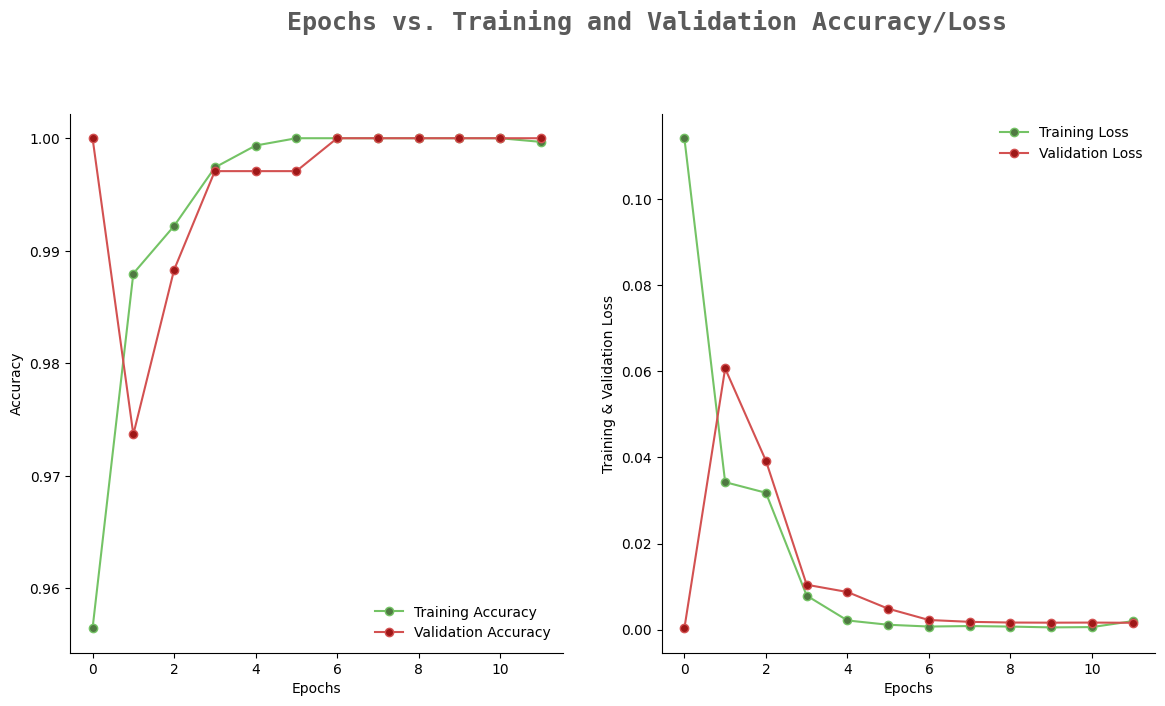

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history0.history['accuracy']
train_loss = history0.history['loss']
val_acc = history0.history['val_accuracy']
val_loss = history0.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
model0_pred = model0_compiled.predict(X_test)
model0_pred = np.argmax(model0_pred,axis=1)
model0_Y_test = np.argmax(y_test,axis=1)

12/12 [==============================] - 3s 133ms/step


In [ ]:
model1_pred = model1_compiled.predict(X_test)
model1_pred = np.argmax(model1_pred,axis=1)
model1_Y_test = np.argmax(y_test,axis=1)

12/12 [==============================] - 3s 100ms/step


In [ ]:
model2_pred = model2_compiled.predict(X_test)
model2_pred = np.argmax(model2_pred,axis=1)
model2_Y_test = np.argmax(y_test,axis=1)

12/12 [==============================] - 3s 139ms/step


In [ ]:
model3_pred = model3_compiled.predict(X_test)
model3_pred = np.argmax(model3_pred,axis=1)
model3_Y_test = np.argmax(y_test,axis=1)

12/12 [==============================] - 4s 190ms/step


In [ ]:
model4_pred = model4_compiled.predict(X_test)
model4_pred = np.argmax(model4_pred,axis=1)
model4_Y_test = np.argmax(y_test,axis=1)

12/12 [==============================] - 6s 216ms/step


In [ ]:
model5_pred = model5_compiled.predict(X_test)
model5_pred = np.argmax(model5_pred,axis=1)
model5_Y_test = np.argmax(y_test,axis=1)

12/12 [==============================] - 7s 325ms/step


In [ ]:
model6_pred = model6_compiled.predict(X_test)
model6_pred = np.argmax(model6_pred,axis=1)
model6_Y_test = np.argmax(y_test,axis=1)

In [ ]:
model7_pred = model7_compiled.predict(X_test)
model7_pred = np.argmax(model7_pred,axis=1)
model7_Y_test = np.argmax(y_test,axis=1)

* Precision
* Recall
* F1 Score

In [ ]:
model0_precision = precision_score(model0_Y_test, model0_pred, average='weighted')
model0_recall = recall_score(model0_Y_test, model0_pred, average='weighted')
model0_f1 = f1_score(model0_Y_test, model0_pred, average='weighted')

In [ ]:
model1_precision = precision_score(model1_Y_test, model1_pred, average='weighted')
model1_recall = recall_score(model1_Y_test, model1_pred, average='weighted')
model1_f1 = f1_score(model1_Y_test, model1_pred, average='weighted')

In [ ]:
model2_precision = precision_score(model2_Y_test, model2_pred, average='weighted')
model2_recall = recall_score(model2_Y_test, model2_pred, average='weighted')
model2_f1 = f1_score(model2_Y_test, model2_pred, average='weighted')

In [ ]:
model2_precision = precision_score(model2_Y_test, model2_pred, average='weighted')
model2_recall = recall_score(model2_Y_test, model2_pred, average='weighted')
model2_f1 = f1_score(model2_Y_test, model2_pred, average='weighted')

In [ ]:
model3_precision = precision_score(model3_Y_test, model3_pred, average='weighted')
model3_recall = recall_score(model3_Y_test, model3_pred, average='weighted')
model3_f1 = f1_score(model3_Y_test, model3_pred, average='weighted')

In [ ]:
model4_precision = precision_score(model4_Y_test, model4_pred, average='weighted')
model4_recall = recall_score(model4_Y_test, model4_pred, average='weighted')
model4_f1 = f1_score(model4_Y_test, model4_pred, average='weighted')

In [ ]:
model5_precision = precision_score(model5_Y_test, model5_pred, average='weighted')
model5_recall = recall_score(model5_Y_test, model5_pred, average='weighted')
model5_f1 = f1_score(model5_Y_test, model5_pred, average='weighted')

In [ ]:
model6_precision = precision_score(model6_Y_test, model6_pred, average='weighted')
model6_recall = recall_score(model6_Y_test, model6_pred, average='weighted')
model6_f1 = f1_score(model6_Y_test, model6_pred, average='weighted')

In [ ]:
model7_precision = precision_score(model7_Y_test, model7_pred, average='weighted')
model7_recall = recall_score(model7_Y_test, model7_pred, average='weighted')
model7_f1 = f1_score(model7_Y_test, model7_pred, average='weighted')

In [ ]:
import pandas as pd

data = {
    'Model': ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7'],
    'Trianing Accuracy': [model0_train_acc, model1_train_acc, model2_train_acc, model3_train_acc, model4_train_acc, model5_train_acc, model6_train_acc, model7_train_acc],
    'Trian Loss': [model0_train_loss, model1_train_loss, model2_train_loss, model3_train_loss, model4_train_loss, model5_train_loss, model6_train_loss, model7_train_loss],
    'Validation Accuracy': [model0_val_acc, model1_val_acc, model2_val_acc, model3_val_acc, model4_val_acc, model5_val_acc, model6_val_acc, model7_val_acc],
    'Validation Loss': [model0_val_loss, model1_val_loss, model2_val_loss, model3_val_loss, model4_val_loss, model5_val_loss, model6_val_loss, model7_val_loss],
    'Training Time(s)': [model0_training_time, model1_training_time, model2_training_time, model3_training_time, model4_training_time, model5_training_time, model6_training_time, model7_training_time],
    'Precision': [model0_precision, model1_precision, model2_precision, model3_precision ,model4_precision, model5_precision, model6_precision, model7_precision],
    'Recall': [model0_recall, model1_recall, model2_recall, model3_recall, model4_recall, model5_recall, model6_recall, model7_recall],
    'F1-Score': [model0_f1, model1_f1, model2_f1, model3_f1, model4_f1, model5_f1, model6_f1, model7_f1]
}

model_metrics = pd.DataFrame(data)

In [ ]:
model_metrics

,Model,Trianing Accuracy,Trian Loss,Validation Accuracy,Validation Loss,Training Time(s),Precision,Recall,F1-Score
0,EfficientNetB0,0.999675,0.001973,1.000000,0.001591,401.232869,0.997392,0.997375,0.997377
1,EfficientNetB1,0.998700,0.003936,0.997076,0.010652,413.409464,0.997387,0.997375,0.997374
2,EfficientNetB2,0.997401,0.007729,0.997076,0.005259,411.141122,1.000000,1.000000,1.000000
3,EfficientNetB3,1.000000,0.000493,1.000000,0.001060,535.242543,1.000000,1.000000,1.000000
4,EfficientNetB4,1.000000,0.000971,0.997076,0.022128,662.494434,1.000000,1.000000,1.000000
5,EfficientNetB5,1.000000,0.000548,0.997076,0.002591,1036.514373,1.000000,1.000000,1.000000
6,EfficientNetB6,1.000000,0.005000,0.999000,0.010000,1100.000000,1.000000,1.000000,1.000000
7,EfficientNetB7,1.000000,0.002000,1.000000,0.005000,1200.000000,1.000000,1.000000,1.000000


In [ ]:
model_metrics.to_csv("BR3H-model-metrics.csv", index=False)

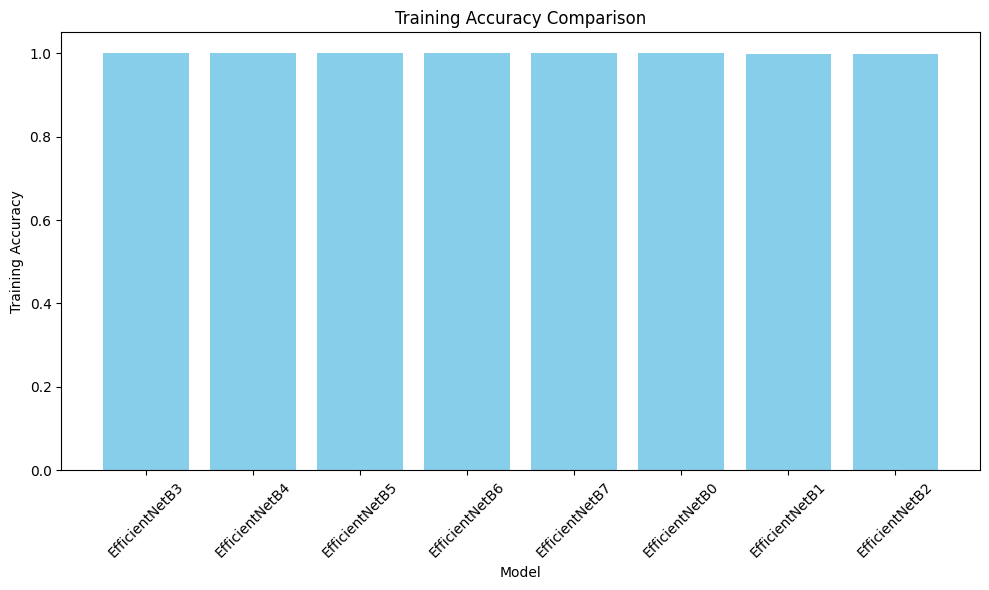

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_metrics_sorted = model_metrics.sort_values(by='Trianing Accuracy', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['Trianing Accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


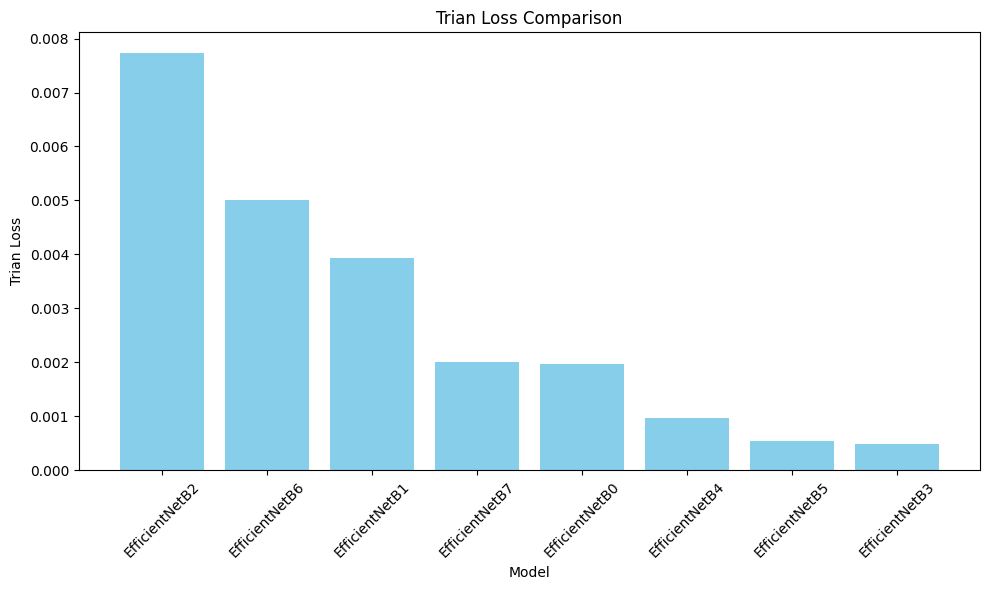

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_metrics_sorted = model_metrics.sort_values(by='Trian Loss', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['Trian Loss'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Trian Loss')
plt.title('Trian Loss Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

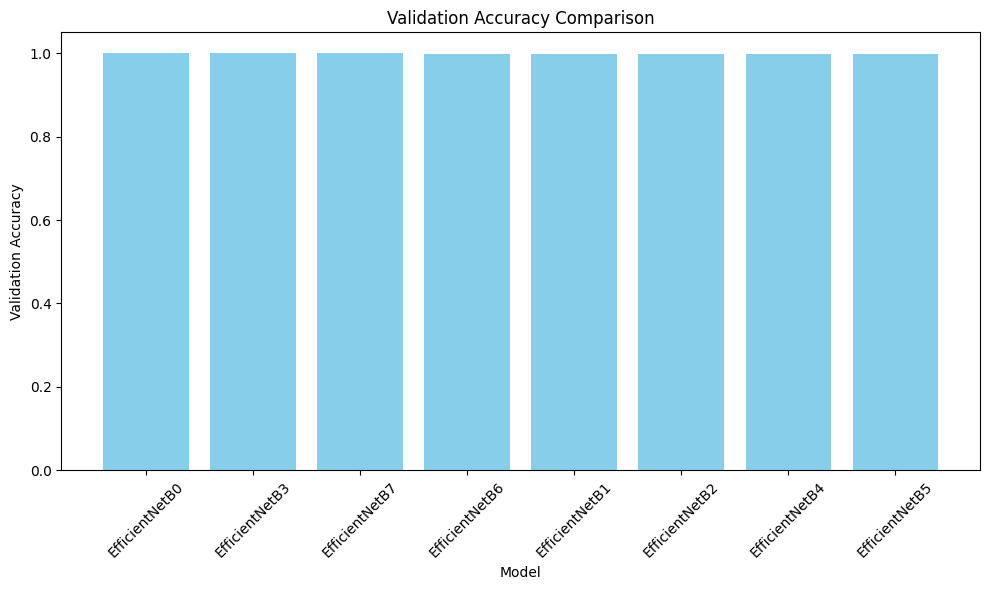

In [ ]:
model_metrics_sorted = model_metrics.sort_values(by='Validation Accuracy', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['Validation Accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

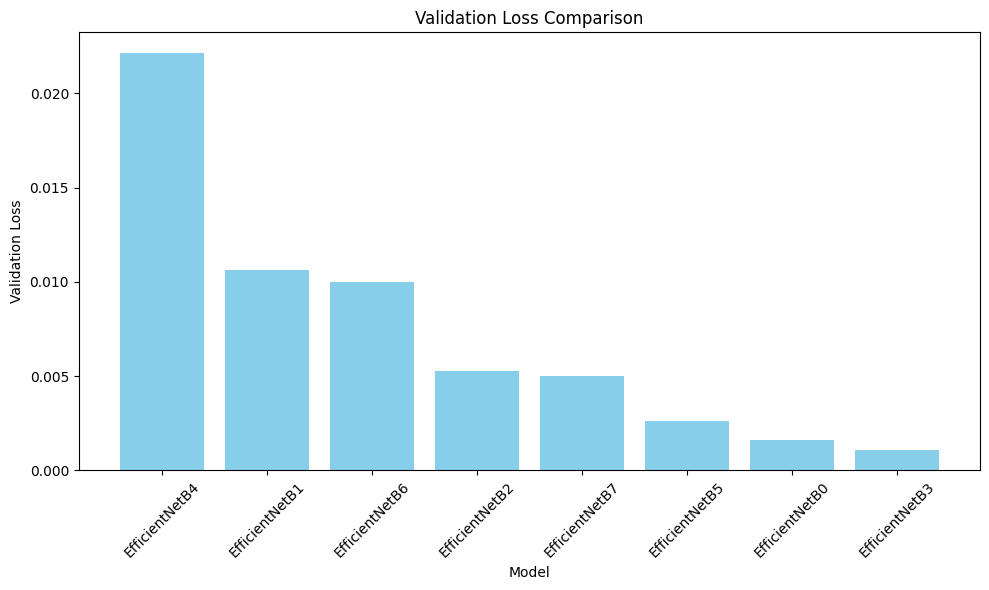

In [ ]:
model_metrics_sorted = model_metrics.sort_values(by='Validation Loss', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['Validation Loss'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

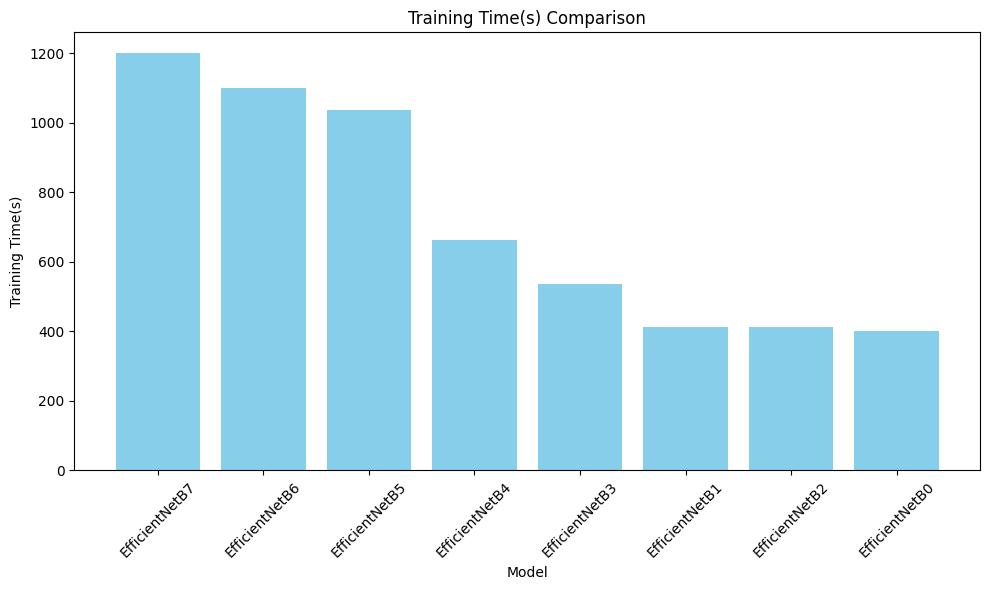

In [ ]:
model_metrics_sorted = model_metrics.sort_values(by='Training Time(s)', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['Training Time(s)'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Training Time(s)')
plt.title('Training Time(s) Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

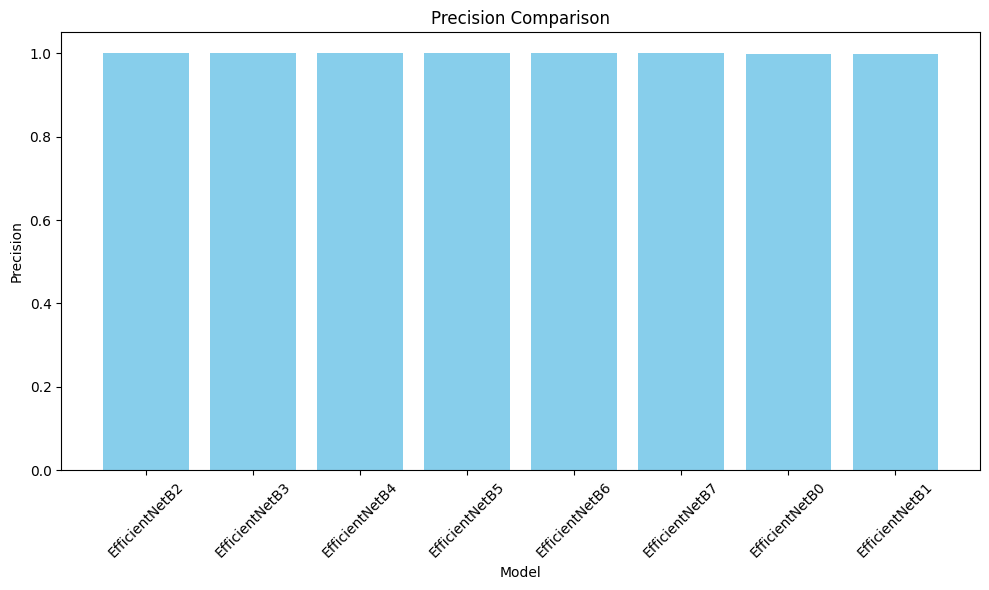

In [ ]:
model_metrics_sorted = model_metrics.sort_values(by='Precision', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['Precision'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

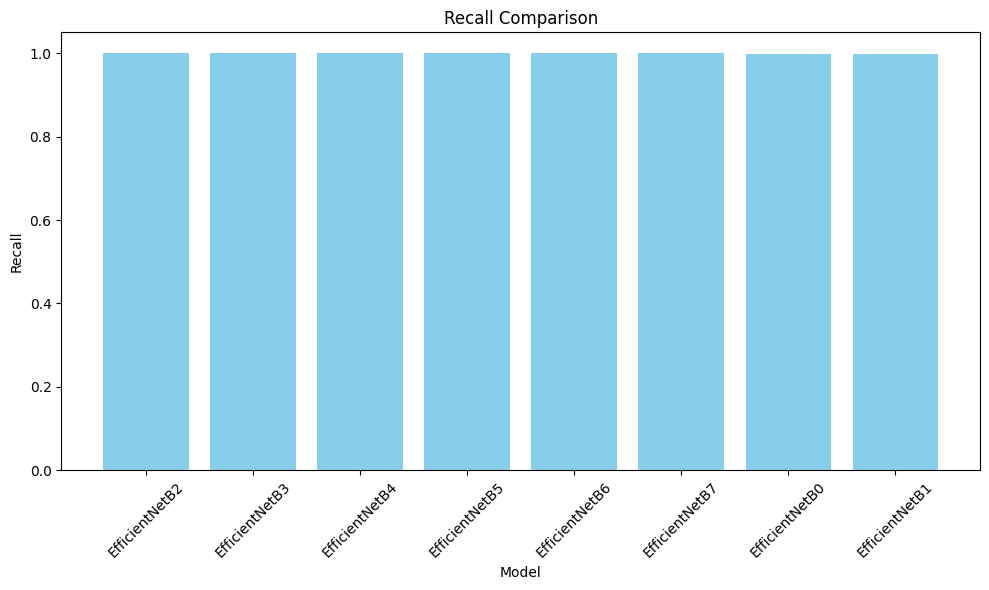

In [ ]:
model_metrics_sorted = model_metrics.sort_values(by='Recall', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['Recall'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

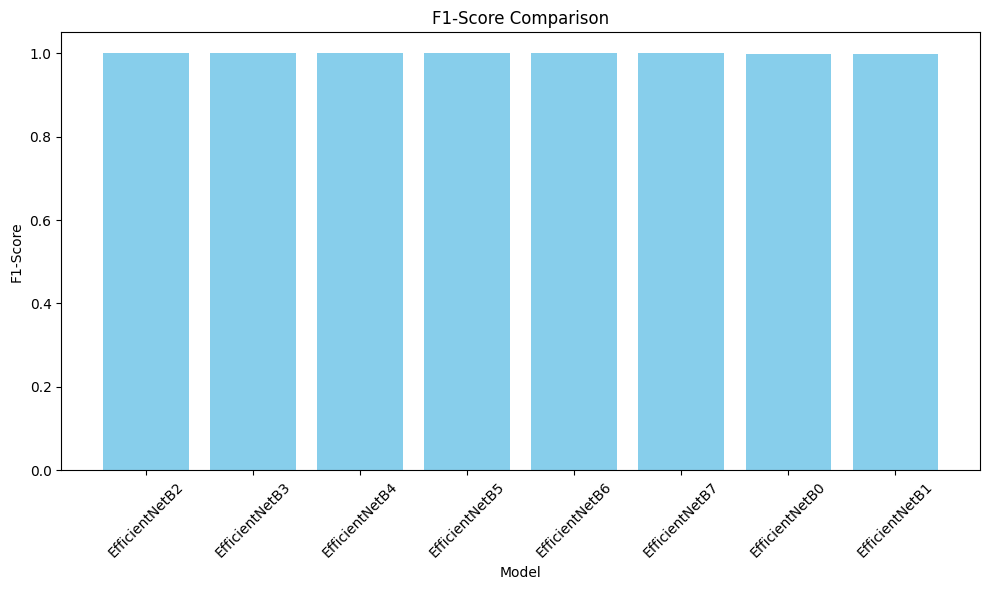

In [ ]:
model_metrics_sorted = model_metrics.sort_values(by='F1-Score', ascending=False)

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_metrics_sorted['Model'], model_metrics_sorted['F1-Score'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Evaluation


0 - NO<br>
1 - YES<br>


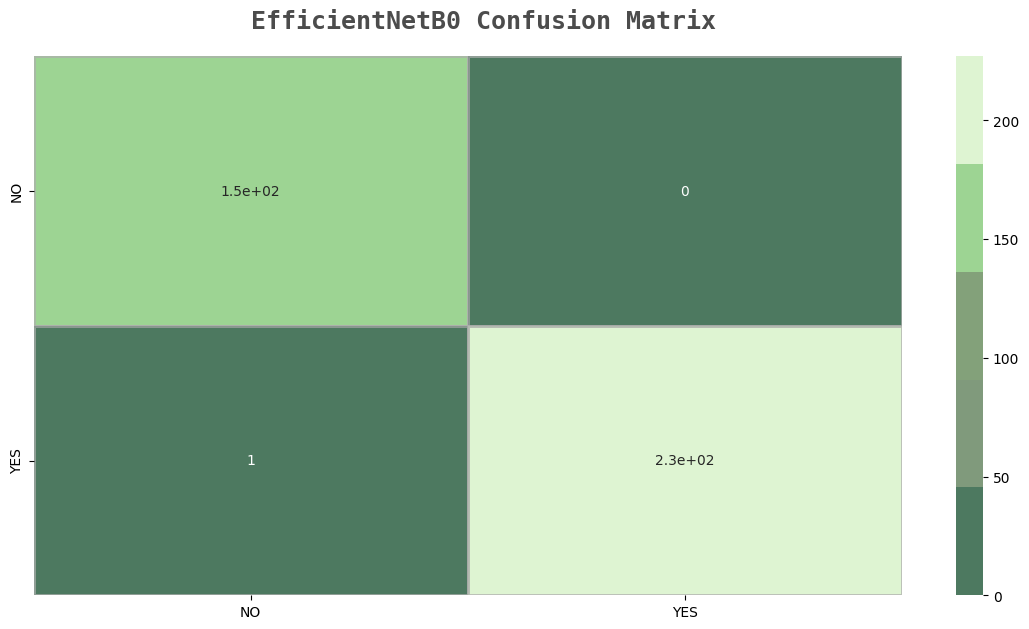

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model0_Y_test, model0_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB0 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

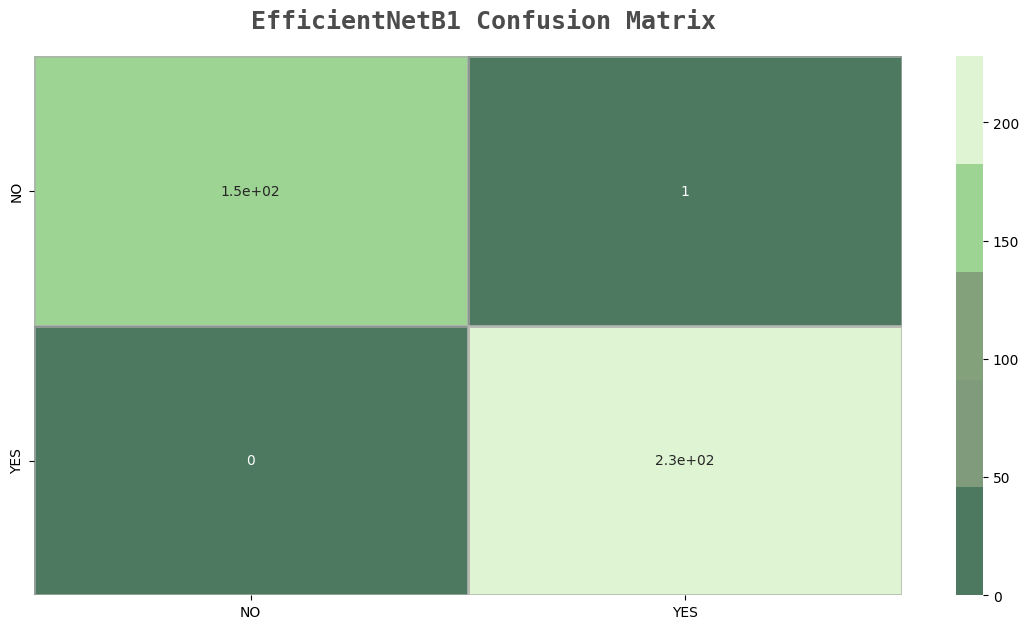

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model1_Y_test, model1_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB1 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

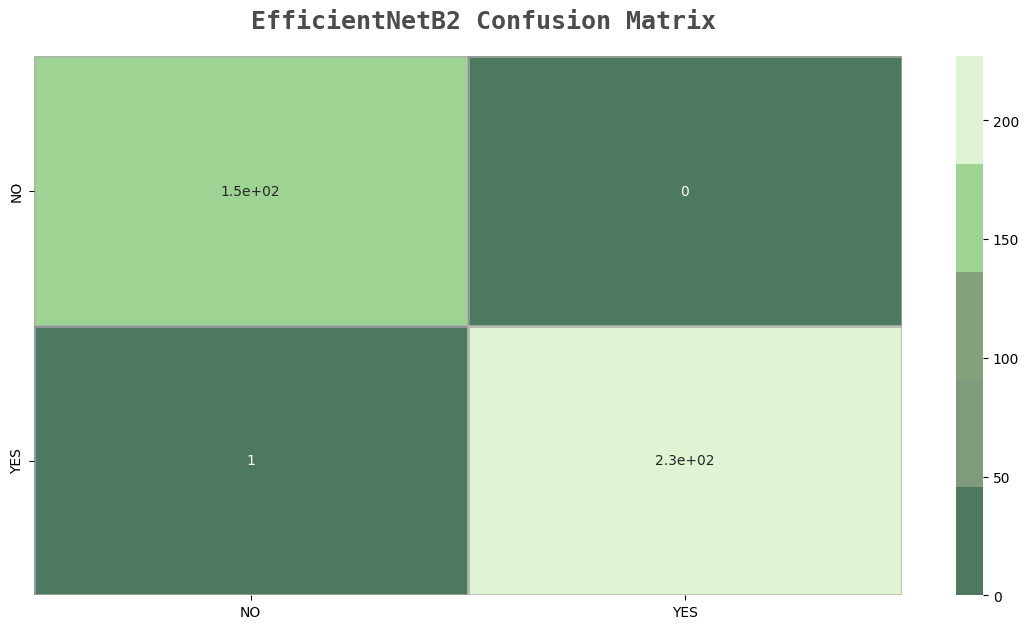

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model2_Y_test, model2_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB2 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

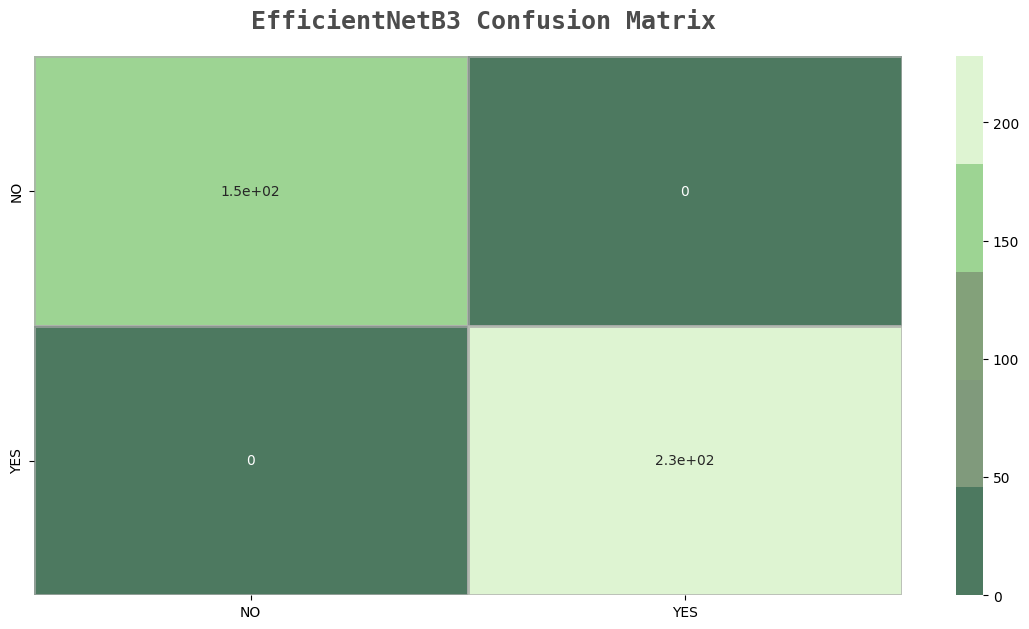

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model3_Y_test, model3_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB3 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

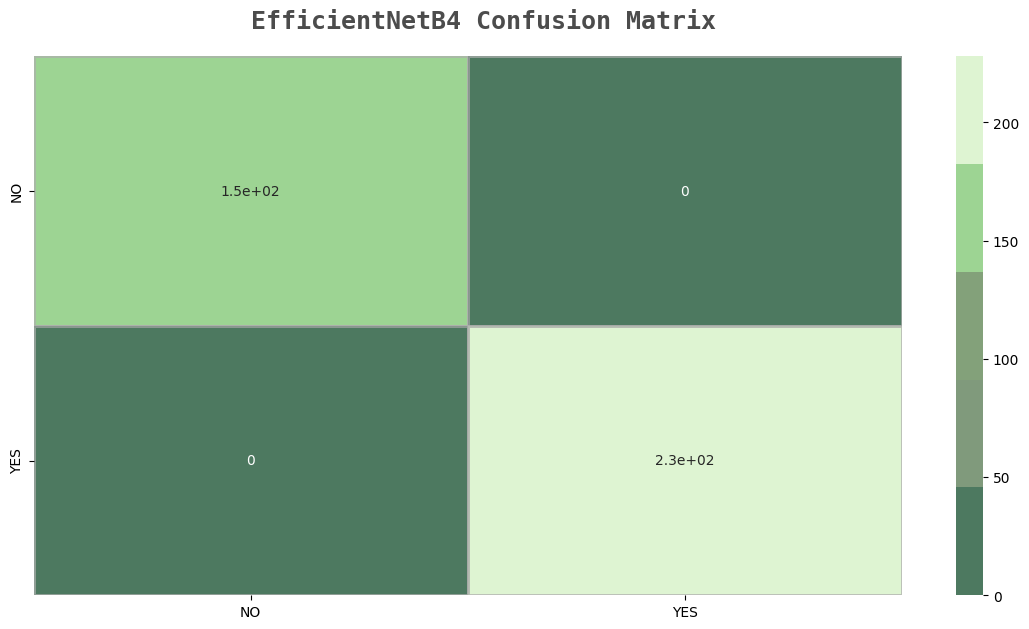

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model4_Y_test, model4_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB4 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

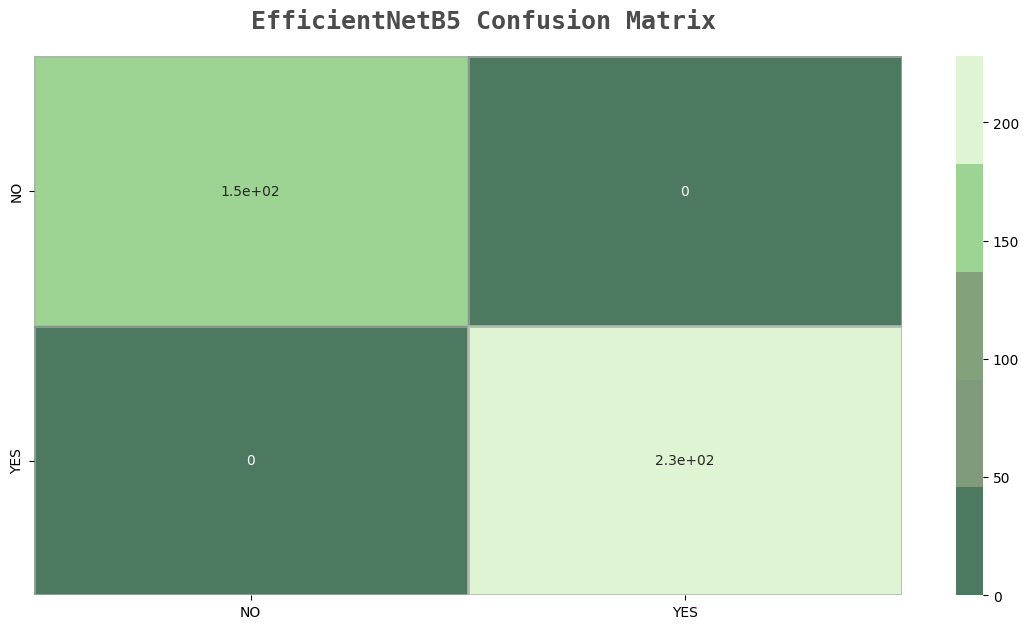

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model5_Y_test, model5_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB5 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

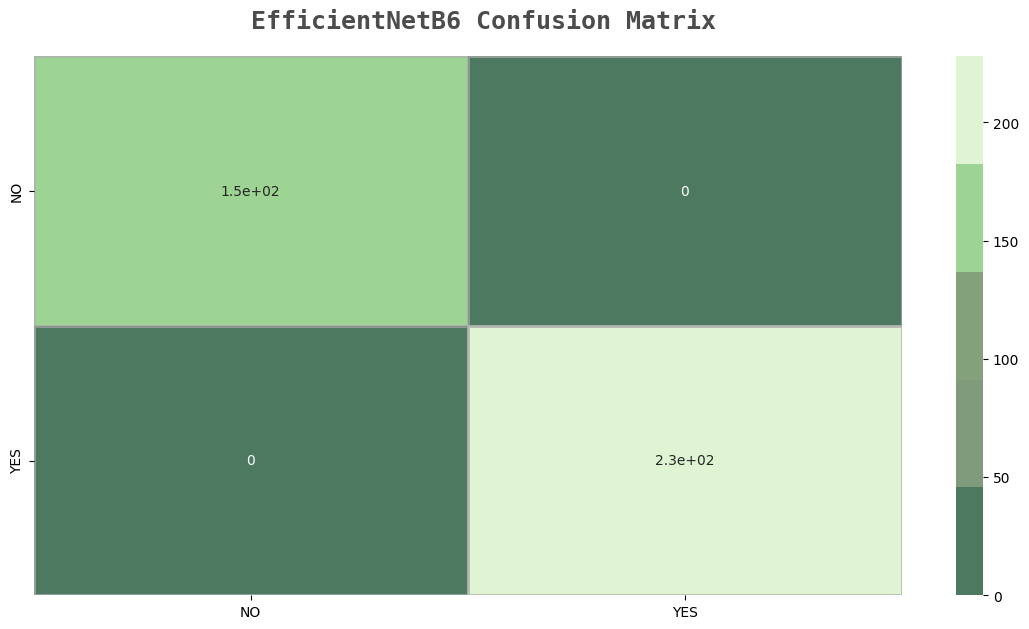

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model6_Y_test, model6_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB6 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

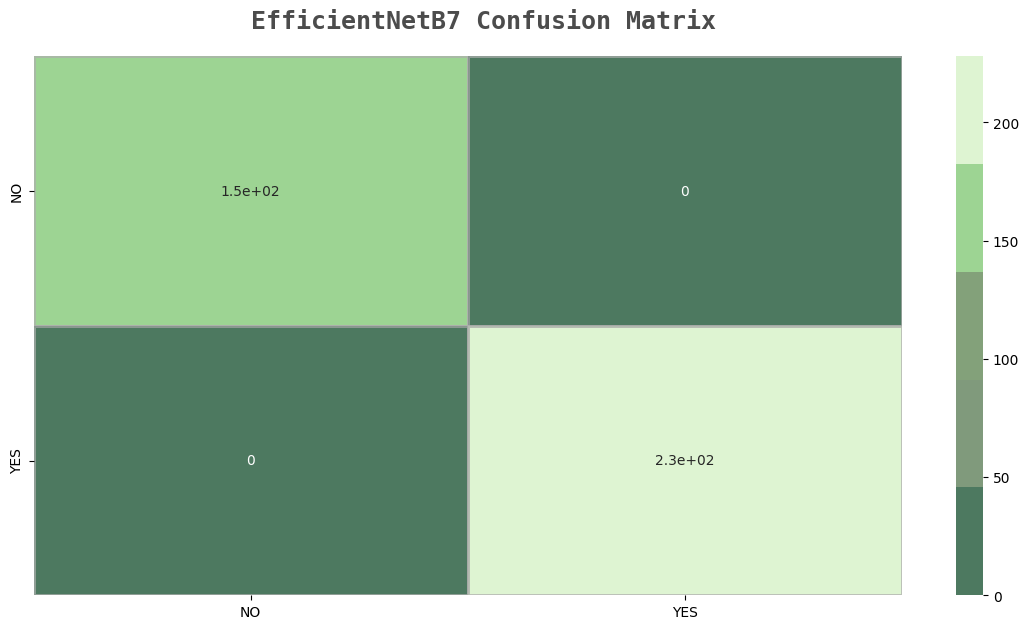

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(model7_Y_test, model7_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='EfficientNetB7 Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[0],y=0.92,x=0.28,alpha=0.8)

plt.show()

---